In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random 
import sys
import matplotlib.pyplot as plt
from collections import defaultdict
PROJECT_ROOT = Path().resolve()          # this should be 02807-project
SRC_DIR = PROJECT_ROOT / "src"
sys.path.append(str(SRC_DIR))
sys.path.insert(0, str(SRC_DIR))

import preprocessing as pp

# Define base directory
DATA_DIR_RAW = Path("data/raw")
DATA_DIR_PROC = Path("data/processed")

# Define file paths
USERS   = DATA_DIR_RAW / "user.json"
REVIEWS = DATA_DIR_RAW / "review.json"
REVIEWS_CLEAN = DATA_DIR_RAW / "review_clean.ndjson"
BIZ     = DATA_DIR_RAW / "business.json"

# categories of restaurants
FOOD = DATA_DIR_RAW / "Food.txt"
RESTAURANTS = DATA_DIR_RAW / "restaurants.txt"

In [ ]:
user = pd.read_json(USERS, lines=True, dtype={"user_id": str}, engine="pyarrow")
user.head()

In [3]:
review = pd.read_json(REVIEWS_CLEAN, lines=True, engine="pyarrow")
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [4]:
df = pd.read_json(BIZ, lines=True, dtype_backend="pyarrow")
print(len(df))

150346


In [5]:
# drop nans 
df = df.dropna(subset=["categories"])
print(len(df))

150243


I was deciding whether to keep or delete the closed businesses from the dataset, I decided to keep them for now.

In [6]:
df[df['is_open'] == 0].describe()

,latitude,longitude,stars,review_count,is_open
count,30640.0,30640.0,30640.0,30640.0,30640.0
mean,36.865302,-88.936441,3.510117,37.776567,0.0
std,5.823943,14.697603,0.878553,71.158114,0.0
min,27.674867,-120.078856,1.0,5.0,0.0
25%,32.227404,-90.310474,3.0,8.0,0.0
50%,38.856831,-86.13085,3.5,15.0,0.0
75%,39.952972,-75.328024,4.0,37.0,0.0
max,53.64949,-74.664459,5.0,1781.0,0.0


In [7]:
# unique categories 
len(df["categories"].unique())

83160

In [8]:
# Keep only the once that contain restaurants/food
is_foodish = df["categories"].str.contains(r"\b(?:Restaurants|Food)\b", case=False, na=False)
df = df[is_foodish]

In [9]:
# unique categories 
len(df["categories"].unique())

37846

In [10]:
# get all the categories in order
CATEGORIES_IN_ORDER = pp.get_categories()

print("n cats:", len(CATEGORIES_IN_ORDER))
print(CATEGORIES_IN_ORDER[:12])


df["simple_category"] = df["categories"].apply(lambda x: pp.simplify_random(x, CATEGORIES_IN_ORDER=CATEGORIES_IN_ORDER))

n cats: 218
['Afghan', 'African', 'Senegalese', 'South African', 'American (New)', 'American (Traditional)', 'Arabian', 'Argentine', 'Armenian', 'Asian Fusion', 'Australian', 'Austrian']


In [11]:
pp.test_distribution(df, n_runs=100, random_seed=1337, CATEGORIES_IN_ORDER=CATEGORIES_IN_ORDER)

Ran 100 random trials.
Average change in category (mean std):   8.802271496322266e-19
Average category share (mean of means):        0.005050505050505052
Average coefficient of variation (mean cv):    1.9400924884298127e-16

Most unstable categories (by CV):
                mean           std            cv
categories                                      
Kebab       0.000108  5.448321e-20  5.029267e-16
Afghan      0.000108  5.448321e-20  5.029267e-16
Pancakes    0.000108  5.448321e-20  5.029267e-16
Olive Oil   0.000433  2.179328e-19  5.029267e-16
Halal       0.000433  2.179328e-19  5.029267e-16
Butcher     0.000433  2.179328e-19  5.029267e-16
Cafeteria   0.000217  1.089664e-19  5.029267e-16
Indonesian  0.000108  5.448321e-20  5.029267e-16
Ramen       0.001315  6.537985e-19  4.970099e-16
Thai        0.011174  5.230388e-18  4.680980e-16


In [12]:
df["categories"].head(10)

3     Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                             Brewpubs, Breweries, Food
5     Burgers, Fast Food, Sandwiches, Food, Ice Crea...
8     Pubs, Restaurants, Italian, Bars, American (Tr...
9     Ice Cream & Frozen Yogurt, Fast Food, Burgers,...
11           Vietnamese, Food, Restaurants, Food Trucks
12    American (Traditional), Restaurants, Diners, B...
14          Food, Delis, Italian, Bakeries, Restaurants
15                    Sushi Bars, Restaurants, Japanese
19                                  Korean, Restaurants
Name: categories, dtype: string[pyarrow]

In [16]:
len(df["simple_category"].unique())

198

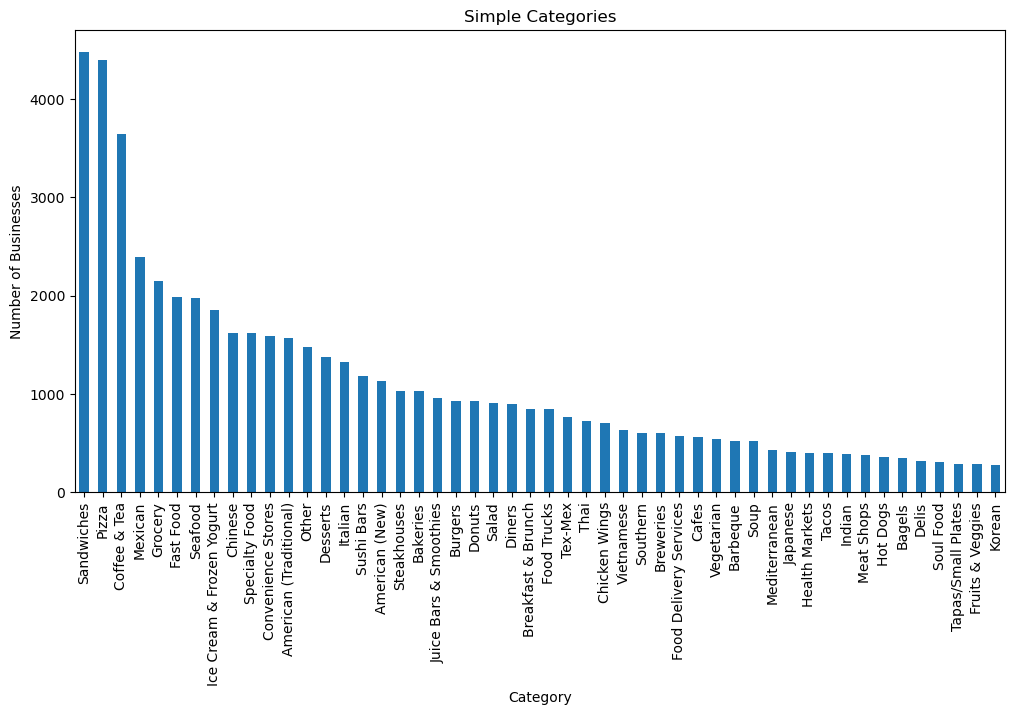

In [21]:
category_counts = df["simple_category"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,6))
category_counts.head(50).plot(kind='bar')
plt.title("Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.show()

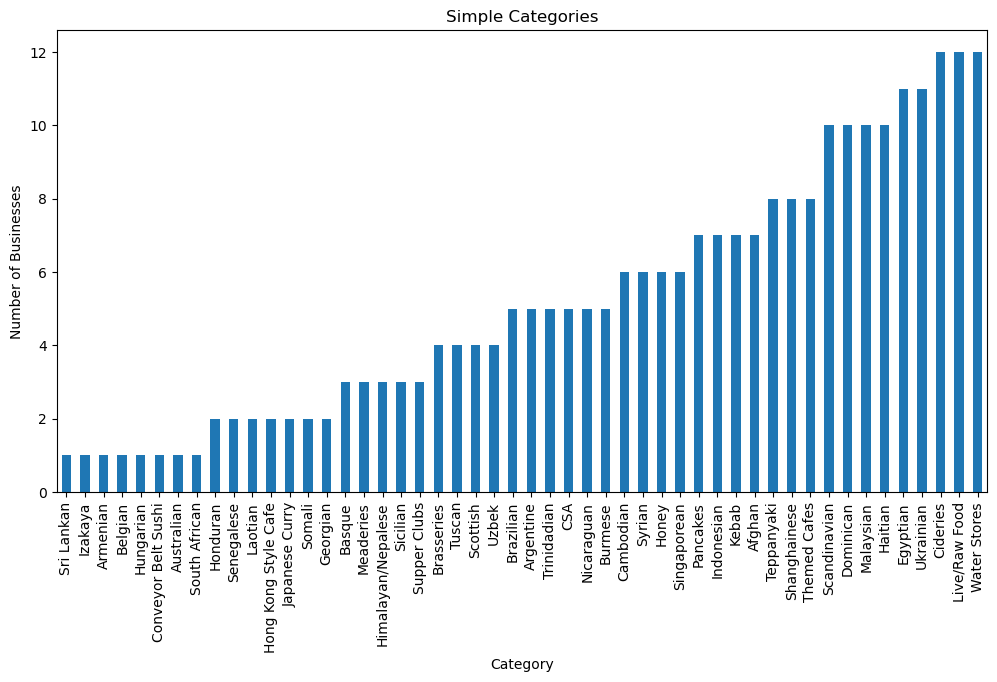

In [20]:
category_counts = df["simple_category"].value_counts().sort_values(ascending=True)
plt.figure(figsize=(12,6))
category_counts.head(50).plot(kind='bar')
plt.title("Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.show()

In [47]:
vc = df["simple_category"].value_counts()
print("Share of the first top 20 companies:", vc.head(20).sum()/vc.sum())


Share of the first top 20 companies: 0.6431843506252322


#### RECODING TO INTEGER VALUES FOR CATEGORIES 

In [48]:
# save the proeccesd dataframe into a parquet file
df.to_parquet(DATA_DIR_PROC / "business_processed.parquet", index=False)

In [49]:
# load the processed dataframe
biz_proc = pd.read_parquet(DATA_DIR_PROC / "business_processed.parquet")[["business_id", "simple_category"]]

# save the business_id column as string[pyarrow] for efficient storage
biz_proc["business_id"]  = biz_proc["business_id"].astype("string[pyarrow]")

print("Length of biz:", len(biz_proc))


Length of biz: 64616


In [50]:
# Create category encoding 
cats = biz_proc["simple_category"].drop_duplicates().sort_values().to_list()
cat_to_id = {cat: idx for idx, cat in enumerate(cats)}

# Save category vocabulary
id2cat = pd.DataFrame({"cat_id": range(len(cats)), "simple_category": cats})
id2cat.to_parquet(DATA_DIR_PROC / "cat_vocab.parquet", index=False)

# Create reverse mapping for later use
id2cat_map = {i: c for i, c in enumerate(cats)}

In [51]:
# apply the encoding and create business mapping 
# Apply encoding and create business mapping
biz_proc["cat_id"] = biz_proc["simple_category"].map(cat_to_id).astype("int32[pyarrow]")
biz_map = biz_proc[["business_id", "simple_category", "cat_id"]].drop_duplicates("business_id").set_index("business_id")
print(f"Created mappings for {len(cats)} categories")

Created mappings for 201 categories


In [52]:
# process the reviews in chunks 

RV_PARTS = DATA_DIR_PROC / "reviews_cat_parts"
RV_PARTS.mkdir(parents=True, exist_ok=True)

usecols = ["user_id", "business_id", "stars"]
part = 0


In [54]:
for chunk in pd.read_json(REVIEWS_CLEAN, lines=True, dtype_backend="pyarrow", chunksize=500_000):
    r = chunk[usecols].dropna(subset=["user_id", "business_id", "stars"]).copy()
    r["user_id"] = r["user_id"].astype("string[pyarrow]")
    r["business_id"] = r["business_id"].astype("string[pyarrow]")
    
    r = r[r["user_id"].isin(user["user_id"])]
    if r.empty:
        continue
    
    # Split by stars and join with business mapping
    high = r[r["stars"] >= 4.0]
    low = r[r["stars"] < 3.0]
    
    
    
    if len(high):
        high = high.join(biz_map, on="business_id", how="inner")
        if len(high):
            high.to_parquet(RV_PARTS / f"high_{part:05d}.parquet", index=False)
    
    if len(low):
        low = low.join(biz_map, on="business_id", how="inner")
        if len(low):
            low.to_parquet(RV_PARTS / f"low_{part:05d}.parquet", index=False)
    
    part += 1

print("Wrote parts:", part)


Wrote parts: 10


In [56]:
liked_ids = defaultdict(set)
hated_ids = defaultdict(set)

for p in sorted(RV_PARTS.glob("high_*.parquet")):
    t = pd.read_parquet(p, columns=["user_id", "cat_id"])
    for uid, sub in t.groupby("user_id"):
        liked_ids[str(uid)].update(sub["cat_id"].unique().tolist())

for p in sorted(RV_PARTS.glob("low_*.parquet")):
    t = pd.read_parquet(p, columns=["user_id", "cat_id"])
    for uid, sub in t.groupby("user_id"):
        hated_ids[str(uid)].update(sub["cat_id"].unique().tolist())

# Create baskets with integer IDs
liked_baskets_ids = pd.DataFrame({
    "user_id": list(liked_ids.keys()),
    "items": [sorted(list(s)) for s in liked_ids.values()]
})
hated_baskets_ids = pd.DataFrame({
    "user_id": list(hated_ids.keys()),
    "items": [sorted(list(s)) for s in hated_ids.values()]
})

# Create baskets with string categories
liked_baskets_str = liked_baskets_ids.assign(
    items=lambda d: [[id2cat_map[i] for i in arr] for arr in d["items"]]
)
hated_baskets_str = hated_baskets_ids.assign(
    items=lambda d: [[id2cat_map[i] for i in arr] for arr in d["items"]]
)

# Filter baskets with at least 2 items
#liked_baskets_ids = liked_baskets_ids[liked_baskets_ids["items"].map(len) >= 2]
#liked_baskets_ids = liked_baskets_ids[liked_baskets_ids["items"].map(len)]
#hated_baskets_ids = hated_baskets_ids[hated_baskets_ids["items"].map(len) >= 2]
#hated_baskets_ids = hated_baskets_ids[hated_baskets_ids["items"].map(len)]
#liked_baskets_str = liked_baskets_str[liked_baskets_str["items"].map(len) >= 2]
#liked_baskets_str = liked_baskets_str[liked_baskets_str["items"].map(len)]
#hated_baskets_str = hated_baskets_str[hated_baskets_str["items"].map(len) >= 2]
#hated_baskets_str = hated_baskets_str[hated_baskets_str["items"].map(len)]

# Save all basket variants
liked_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_liked_ids.parquet", index=False)
hated_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_hated_ids.parquet", index=False)
liked_baskets_str.to_parquet(DATA_DIR_PROC / "baskets_liked_str.parquet", index=False)
hated_baskets_str.to_parquet(DATA_DIR_PROC / "baskets_hated_str.parquet", index=False)

print(f"Liked baskets: {len(liked_baskets_ids)} users")
print(f"Hated baskets: {len(hated_baskets_ids)} users")

Liked baskets: 900566 users
Hated baskets: 443351 users
